In [1]:
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
import json
#import seaborn as sns
import numpy as np
import os
import re
import Levenshtein as lev
import seaborn as sns
#import cld2

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [75]:
df[['outlet','category']].drop_duplicates('outlet').to_csv('outlet_mapping.csv',index=False)

In [2]:
df = pd.read_csv('/shared/2/projects/jiaxin/media_ethnicity/data/reg_data_single_full.csv')

In [3]:
data_path = '/shared/0/projects/news-quotes/news_mentions.json'
m_lines = []
mention_dict = defaultdict(list)
url2title = {}
with open(data_path,'r') as f:
    for ln, line in tqdm(enumerate(f)):
        #if ln>=100000:
        #    break
        line = json.loads(line.strip('\n'))
        #tsd, td, tsu = extract(line['Mention URL']) # prints abc, hostname, com
        #domain = td + '.' + tsu # will prints as hostname.com
        #line['domain'] = domain
        for k in line:
            mention_dict[k].append(line[k])
        m_lines.append(line)
        url2title[line['Mention URL']] = line['Mention Title']
mention_df = pd.DataFrame(mention_dict)

4202497it [00:50, 82530.11it/s]


In [4]:
urls_text = {}
meta_dict = {}
# use stories with more than 100 words.
with open('/shared/0/projects/news-quotes/crawl_news/url_text.json', 'r') as ofile:
    for row in tqdm(ofile):
        row = json.loads(row)
        url, text = row['url'], row['text']
        meta_dict[url] = row
        leng = len(text.split(' '))
        if leng > 100 and leng <= 1392:
            urls_text[url] = text
print(len(urls_text))

536302it [00:37, 14158.23it/s]

496286


In [5]:
cat2sub = {
    "Biology": ["Biological Sciences","biological sciences", "Life Sciences", "Biochemistry And Cell Biology", "Genetics", "Immunology", "Medical Physiology", "Environmental Sciences", "Ecology", "Zoology", "Animal Production", "Medical Microbiology", "Neurosciences", "Oncology And Carcinogenesis", "Paediatrics And Reproductive Medicine", "Nutrition and Dietetics"],
    "Physics": ["Astronomical And Space Sciences", "Physical Sciences", "Earth Sciences", "Geology", "Geochemistry", "Oceanography", "Atmospheric Sciences", "Physical Geography and Environmental Geoscience", "Astronomy and Space Sciences", "Optical Physics", "Other Physical Sciences"],
    "Chemistry": ["Chemical Sciences", "Analytical Chemistry", "Inorganic Chemistry", "Organic Chemistry", "Medicinal and Biomolecular Chemistry", "Macromolecular and Materials Chemistry", "Other Chemical Sciences"],
    #"Mathematics": ["Mathematical Sciences", "Applied Mathematics", "Statistics"],
    "Engineering": ["Engineering", "Interdisciplinary Engineering", "Mechanical Engineering", "Electrical and Electronic Engineering", "Biomedical Engineering", "Materials Engineering", "Information And Computing Sciences", "Artificial Intelligence and Image Processing"],
    "Social Science": ["Sociology", "Studies in Human Society", "Anthropology", "Archaeology", "Political Science", "Policy and Administration", "Demography", "Psychology", "Psychology and Cognitive Sciences", "Applied Economics"],
    "Humanities": ["Education", "Specialist Studies in Education", "Curriculum and Pedagogy", "Marketing", "Business and Management", "Banking, Finance and Investment", "Commerce, Management, Tourism and Services", "Law", "Dentistry", "Environmental Science and Management", "Environmental Engineering", "History and Philosophy of Specific Fields", "Art History", "Applied Ethics", "Cultural Studies", "Philosophy", "History"],
    #"Computer Science": [],
    "Medical": ["Nursing", "Complementary And Alternative Medicine", "medical and health sciences", "Medical And Health Sciences", "Medical And Health Sciences", "cardiovascular medicine and haematology","public health and health services", "Clinical Sciences", "Public Health and Health Services", "Ophthalmology and Optometry", "Dental Sciences", "Veterinary Sciences", "Human Movement and Sports Science", "Microbiology", "Medical Biochemistry and Metabolomics", "Medicinal and Biomolecular Chemistry", "Other Medical and Health Sciences"],
}
category_mapping = {}
for big_category, subcategories in cat2sub.items():
    for subcategory in subcategories:
        category_mapping[subcategory.lower()] = big_category

In [6]:
df['Mention title'] = [url2title[it] if it in url2title else None for it in df['url']]
df['raw_text'] = [urls_text[it] if it in urls_text else None for it in df['url']]

In [7]:
df.groupby('doi').count()['has_indirect_mention'].sort_values()

doi
10.1001/2012.jama.11374          1
10.1088/0004-637x/712/2/763      1
10.1088/0004-637x/716/2/1381     1
10.1088/0004-637x/719/1/763      1
10.1088/0004-637x/729/2/142      1
                                ..
10.4103/jfmpc.jfmpc_109_18      59
10.1126/science.1260352         64
10.1073/pnas.1320040111         75
10.1002/lary.25346              80
10.1056/nejmsa1803972           99
Name: has_indirect_mention, Length: 59041, dtype: int64

<Axes: >

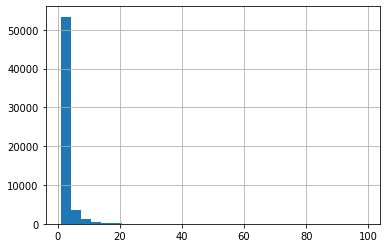

In [8]:
df.groupby('doi').count()['has_indirect_mention'].hist(bins=30)

In [154]:
np.percentile(df.groupby('doi').count()['has_indirect_mention'], 75)

2.0

In [9]:
unique_df = df#.drop_duplicates('Mention title')
unique_df = unique_df[~unique_df['raw_text'].isna()]
unique_df = unique_df[~unique_df['Mention title'].isna()]
unique_df = unique_df[unique_df['outlet']!='MSN']

In [11]:
unique_df['cleaned_text'] = [clean_text(it) for it in tqdm(unique_df['raw_text'])]

100%|██████████| 125685/125685 [09:31<00:00, 220.00it/s]


In [12]:
unique_df = distance_to_pr(unique_df, 'cleaned_text')

125685it [30:49, 67.96it/s] 


<Axes: xlabel='distance_to_pr', ylabel='Count'>

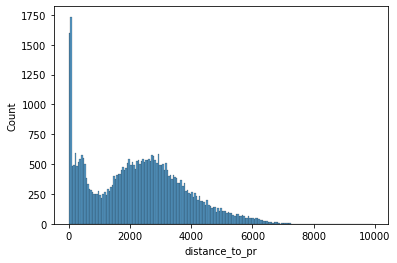

In [1073]:
sns.histplot(unique_df[unique_df.category!='PressRelease'].distance_to_pr, binwidth=50)

In [22]:
unique_df['coverage_cnt'] = unique_df.groupby('doi').transform('count')['has_indirect_mention']

In [12]:
unique_df[unique_df['category'] == 'PressRelease']['outlet'].value_counts()

outlet
Science Daily                 15570
Technology.org                 7082
Health Medicinet               5418
Newswise                       4980
Futurity                       3514
Nanowerk                       3042
Physician's Briefing           1120
7th Space Family Portal         781
PR Newswire                     668
Environmental News Network      642
MIT News                        381
AJMC                            297
Emaxhealth.com                  244
Cornell Chronicle               186
PR Web                          182
Bio-Medicine.org                157
Relief Web                       99
Name: count, dtype: int64

In [13]:
domain_classification = {"Medicine": "Medicine",'Engineering':'Engineering', "Law": "Others", "Condensed_matter_physics": "Science", "Biomedical_engineering": "Engineering", "Hydrology": "Science", "Atomic_physics": "Science", "Development_economics": "Social Science", "Optics": "Science", "Public_policy": "Social Science", "Lung_cancer": "Medicine", "Electronic_engineering": "Engineering", "Artificial_intelligence": "Engineering", "Machine_learning": "Engineering", "Gender_studies": "Social Science", "Chemical_engineering": "Engineering", "Biophysics": "Science", "Analytical_chemistry": "Science", "Computer_science": "Engineering", "Radiology": "Medicine", "Urology": "Medicine", "Architecture": "Engineering", "Quantum_mechanics": "Science", "Particle_physics": "Science", "Materials_science": "Science", "Computational_biology": "Science", "Agronomy": "Science", "Environmental_resource_management": "Science", "Molecular_biology": "Science", "Dermatology": "Medicine", "Surgery": "Medicine", "Public_health": "Medicine", "Molecular_physics": "Science", "Bioinformatics": "Science", "Physics": "Science", "Cognitive_psychology": "Social Science", "Oncology": "Medicine", "Pathology": "Medicine", "Biochemistry": "Science", "Social_science": "Social Science", "Climatology": "Science", "Pharmacology": "Medicine", "Agriculture": "Science", "Neuroscience": "Medicine", "Fishery": "Science", "Virology": "Science", "Microbiology": "Science", "Communication": "Social Science", "Endocrinology": "Medicine", "Epigenetics": "Medicine", "Marketing": "Social Science", "Global_health": "Medicine", "Agroforestry": "Science", "Chemistry": "Science", "Mathematics": "Science", "Gynecology": "Medicine", "Gerontology": "Medicine", "Meteorology": "Science", "Veterinary_medicine": "Medicine", "Government": "Social Science", "Dentistry": "Medicine", "Microeconomics": "Social Science", "Sociology": "Social Science", "Emergency_medicine": "Medicine", "Pediatrics": "Medicine", "Advertising": "Social Science", "Oceanography": "Science", "Developmental_psychology": "Social Science", "Internal_medicine": "Medicine", "Cardiology": "Medicine", "Environmental_engineering": "Engineering", "General_surgery": "Medicine", "Environmental_science": "Science", "Geophysics": "Science", "Immunology": "Medicine", "Clinical_psychology": "Social Science", "Toxicology": "Medicine", "Ecology": "Science", "Biology": "Science", "Epidemiology": "Medicine", "Physical_therapy": "Medicine", "Physiology": "Science", "Statistics": "Science", "Psychopathology": "Science", "Animal_science": "Science", "Nursing": "Medicine", "Seismology": "Science", "History": "Humanities", "Psychiatry": "Medicine", "Zoology": "Science", "Psychology": "Social Science", "Etiology": "Science", "Geomorphology": "Science", "Atmospheric_sciences": "Science", "Geography": "Science", "Demography": "Social Science", "Geology": "Science", "Family_medicine": "Medicine", "Evolutionary_biology": "Science", "Astrobiology": "Science", "Astronomy": "Science", "Astrophysics": "Science", "Geochemistry": "Science", "Business": "Social Science", "Finance": "Social Science", "Management_science": "Social Science", "Social_psychology": "Social Science", "Political_science": "Social Science", "Archaeology": "Social Science", "Economics": "Social Science", "Paleontology": "Science", "Criminology": "Social Science"}
def get_single_field(s_df):
    #fields = ['Composite_material', 'Chemistry', 'Chromatography', 'Botany', 'Surgery', 'Medicine', 'Cognitive_psychology', 'Affect__psychology_', 'Aggression', 'Psychology', 'Psychiatry', 'Cell_biology', 'Transcriptome', 'Molecular_biology', 'Carcinogenesis', 'Biology', 'Human_sexuality', 'Physical_therapy', 'Testosterone', 'Psychotherapist', 'Prostate_cancer', 'Mood', 'Disease', 'Genetics', 'Genome', 'Randomized_controlled_trial', 'Quality_of_life', 'Comorbidity', 'Severity_of_illness', 'Diabetes_mellitus', 'Prospective_cohort_study', 'Ideology', 'China', 'Law', 'Sociology', 'Environmental_engineering', 'Environmental_resource_management', 'Economics', 'Climate_change', 'Population', 'Evolutionary_biology', 'Cell', 'Phylogenetics', 'Ecology', 'Taxon', 'Biodiversity', 'Atmospheric_sciences', 'Environmental_science', 'Global_warming', 'Meteorology', 'Pedagogy', 'Social_science', 'Social_psychology', 'Confidence_interval', 'Referral', 'Young_adult', 'Medical_prescription', 'Molecule', 'Organic_chemistry', 'Materials_science', 'Environmental_health', 'Obesity', 'Body_mass_index', 'Public_health', 'Biochemistry', 'Endocrinology', 'Internal_medicine', 'Mitochondrion', 'Democracy', 'Political_economy', 'Public_administration', 'Politics', 'Public_opinion', 'Gerontology', 'Cohort_study', 'Lower_risk', 'Developmental_psychology', 'Paleontology', 'Geology', 'Neuroscience', 'Biophysics', 'RNA', 'Atomic_physics', 'Physics', 'Ion', 'Photon', 'Optics', 'Climatology', 'Geography', 'Precipitation', 'Chemical_engineering', 'Membrane', 'Inorganic_chemistry', 'Environmental_chemistry', 'Psychological_resilience', 'Risk_assessment', 'Cardiology', 'Cause_of_death', 'Atrial_fibrillation', 'Stimulus__physiology_', 'Schizophrenia', 'Neuroimaging', 'Perception', 'Intensive_care_medicine', 'Nursing', 'Developing_country', 'Health_care', 'Drug', 'Distress', 'Political_science', 'Prefrontal_cortex', 'Social_relation', 'Chromatin', 'Microbiology', 'Antimicrobial', 'Antibiotics', 'Pregnancy', 'Pathology', 'Applied_psychology', 'Cognition', 'Anxiety', 'Radiology', 'Radiation_therapy', 'Biopsy', 'Chemotherapy', 'Multimedia', 'Autism', 'Socioeconomics', 'Agriculture', 'Gynecology', 'Breast_cancer', 'Obstetrics', 'Gestation', 'Pharmacology', 'Clinical_trial', 'Food_science', 'Escherichia_coli', 'Bacteria', 'Photochemistry', 'Injury_prevention', 'Human_factors_and_ergonomics', 'Suicide_prevention', 'Social_environment', 'Occupational_safety_and_health', 'Heart_failure', 'Predation', 'In_vivo', 'CRISPR', 'Crop', 'Carbon', 'Public_relations', 'Demography', 'Dentistry', 'Logistic_regression', 'Health_equity', 'Medicaid', 'Epidemiology', 'Threatened_species', 'Species_richness', 'Harm', 'Classical_mechanics', 'Quantum_mechanics', 'Odds_ratio', 'Homeostasis', 'Type_2_diabetes', 'Cohort', 'Anatomy', 'Interpersonal_relationship', 'Norm__social_', 'Crystallography', 'Physiology', 'Placebo', 'MEDLINE', 'Pediatrics', 'Adverse_effect', 'Transplantation', 'Dopamine', 'Embryonic_stem_cell', 'Criminology', 'Astrophysics', 'Astronomy', 'Condensed_matter_physics', 'Optoelectronics', 'Molecular_physics', 'Nanotechnology', 'Crystal', 'Animal_science', 'Sediment', 'Melanoma', 'Cell_culture', 'Electronic_engineering', 'Odds', 'Overweight', 'Confounding', 'Communication', 'Child_development', 'Psychological_intervention', 'Gene', 'Management_science', 'Offspring', 'Epigenetics', 'Mental_health', 'Well_being', 'Immigration', 'Coping__psychology_', 'Physical_exercise', 'Personality', 'Particle_physics', 'Alternative_medicine', 'Immunology', 'Big_Five_personality_traits', 'PsycINFO', 'Happiness', 'Extinction', 'Environmental_protection', 'Land_use', 'Agroforestry', 'Vegetation', 'Habitat', 'Ecosystem', 'Mineralogy', 'Geochemistry', 'Economic_growth', 'Vaccination', 'Recall', 'Working_memory', 'Radiation', 'Atmosphere', 'Vulnerability', 'Catalysis', 'Anesthesia', 'Toxicology', 'Cannabis', 'Government', 'European_union', 'Risk_factor', 'Systematic_review', 'General_surgery', 'Clinical_endpoint', 'Lung_cancer', 'Polymer', 'Geophysics', 'Geomorphology', 'Advertising', 'Cross_sectional_study', 'Interquartile_range', 'Weight_loss', 'Health_promotion', 'Academic_achievement', 'Finance', 'Chronic_pain', 'Immune_system', 'T_cell', 'Immunity', 'Virology', 'Dementia', 'Alzheimer_s_disease', 'Socioeconomic_status', 'Allele', 'Insulin', 'Hormone', 'Evidence_based_medicine', 'Meta_analysis', 'Medical_emergency', 'Zoology', 'Actuarial_science', 'Hydrology', 'Functional_magnetic_resonance_imaging', 'Electroencephalography', 'Machine_learning', 'Artificial_intelligence', 'Clinical_psychology', 'Nanoparticle', 'Laser', 'Ethnic_group', 'Cancer', 'Magnetic_field', 'Antigen', 'Antibody', 'Seismology', 'Addiction', 'Vitamin_D_and_neurology', 'Athletes', 'Marketing', 'Receptor', 'Social_support', 'Sleep_deprivation', 'Microeconomics', 'Legislation', 'Transcription_factor', 'Fertility', 'Dermatology', 'Pathogenesis', 'Apoptosis', 'Proinflammatory_cytokine', 'Ovarian_cancer', 'Stem_cell', 'Multivariate_analysis', 'Fishery', 'Mortality_rate', 'Virulence', 'Malaria', 'Knowledge_management', 'Analytical_chemistry', 'Graphene', 'Semiconductor', 'Coronary_artery_disease', 'Heart_disease', 'Cholesterol', 'Veterinary_medicine', 'Engineering', 'Biomarker__medicine_', 'Electron', 'Microbiome', 'Gut_flora', 'Physical_medicine_and_rehabilitation', 'Stroke', 'Bioinformatics', 'Body_weight', 'Arctic', 'Poverty', 'Exoplanet', 'Planet', 'Stars', 'Foraging', 'National_Health_and_Nutrition_Examination_Survey', 'Urine', 'Hazard_ratio', 'Observational_study', 'Proportional_hazards_model', 'Inflammation', 'Kidney_disease', 'Gastroenterology', 'Text_mining', 'Locus__genetics_', 'Genome_wide_association_study', 'Urology', 'Ranging', 'Survival_rate', 'Incentive', 'Phenomenon', 'Statistics', 'Longitudinal_study', 'Brain_mapping', 'Metabolic_syndrome', 'Agronomy', 'Asthma', 'Relative_risk', 'Breastfeeding', 'Endangered_species', 'Climate_model', 'Social_perception', 'Social_media', 'Social_network', 'Business', 'Etiology', 'Mesenchymal_stem_cell', 'Weight_gain', 'Mathematics', 'Nicotine', 'Emergency_department', 'Myocardial_infarction', 'Emergency_medicine', 'Labour_economics', 'Health_policy', 'Qualitative_research', 'Clinical_Practice', 'Guideline', 'Wildlife', 'Family_medicine', 'Regulation_of_gene_expression', 'Cellular_differentiation', 'microRNA', 'Downregulation_and_upregulation', 'Computer_science', 'Developed_country', 'Demographic_economics', 'Colorectal_cancer', 'Nutrient', 'Mutant', 'Cancer_research', 'Allergy', 'Biological_dispersal', 'Magnetic_resonance_imaging', 'Transmission__mechanics_', 'Retrospective_cohort_study', 'Metastasis', 'Feeling', 'Metabolism', 'Signal_transduction', 'Traumatic_brain_injury', 'Genomics', 'DNA_methylation', 'Oncology', 'Mutation', 'Phenotype', 'Smoking_cessation', 'Black_hole', 'Air_pollution', 'Hippocampus', 'Biotechnology', 'Biomass', 'Volcano', 'Longevity', 'Empathy', 'Psychosocial', 'Greenhouse_gas', 'Focus_group', 'Regimen', 'Fetus', 'Computer_vision', 'Computational_biology', 'Gene_expression', 'DNA', 'Nuclear_magnetic_resonance', 'Solar_System', 'Astrobiology', 'Audiology', 'Circadian_rhythm', 'Rehabilitation', 'Toxicity', 'Global_health', 'Reproductive_health', 'Neurodegeneration', 'Galaxy', 'Virus', 'Innate_immune_system', 'Early_childhood', 'Amygdala', 'Vitamin', 'Adipose_tissue', 'Architecture', 'Data_mining', 'Quantum', 'Blood_pressure', 'Waste_management', 'Sustainability', 'Incidence__epidemiology_', 'Substance_abuse', 'In_vitro', 'The_Internet', 'Attention_deficit_hyperactivity_disorder', 'Opioid', 'DNA_damage', 'Visual_perception', 'Sensory_system', 'Genotype', 'Antibiotic_resistance', 'Multiple_sclerosis', 'Case_control_study', 'Single_nucleotide_polymorphism', 'Cancer_cell', 'Trait', 'Empirical_research', 'Simulation', 'Oxidative_stress', 'Antioxidant', 'Progenitor_cell', 'Lung', 'Oceanography', 'Immunotherapy', 'Cytokine', 'Kinase', 'Development_economics', 'Cell_type', 'Social_cognition', 'Major_depressive_disorder', 'Hippocampal_formation', 'Central_nervous_system', 'Medical_record', 'Psychopathology', 'Skeletal_muscle', 'Transcription__biology_', 'Ecosystem_services', 'Heart_rate', 'Outbreak', 'Phylogenetic_tree', 'Enzyme', 'Genetic_variation', 'Psychosis', 'Pathogen', 'History', 'Atom', 'Arousal', 'Remote_sensing', 'Crossover_study', 'Programmed_cell_death', 'Human_brain', 'Stimulation', 'Scattering', 'Antidepressant', 'Population_study', 'Corporate_governance', 'Interpersonal_communication', 'Osteoporosis', 'Alcohol', 'Biomedical_engineering', 'Induced_pluripotent_stem_cell', 'Demographics', 'Insulin_resistance', 'Autism_spectrum_disorder', 'Mindfulness', 'Limiting', 'Cretaceous', 'Spectroscopy', 'Prosocial_behavior', 'Computer_security', 'Gestational_age', 'Archaeology', 'Welfare', 'Mental_illness', 'Phosphorylation', 'Life_expectancy', 'Spin_half', 'Thin_film', 'Narrative', 'Gender_studies', 'Public_policy', 'Epilepsy', 'Metal', 'Instability', 'Particle', 'Spectral_line', 'Cell_growth', 'Cytotoxic_T_cell', 'Cycling', 'Intracellular', 'Ageing', 'Bipolar_disorder', 'Meal', 'Ingestion', 'DNA_sequencing', 'Amino_acid']
    
    fields = ["Law","Condensed_matter_physics","Biomedical_engineering","Hydrology","Atomic_physics","Development_economics","Optics",
"Public_policy","Lung_cancer","Electronic_engineering","Artificial_intelligence","Machine_learning","Gender_studies","Chemical_engineering",
"Biophysics","Analytical_chemistry","Computer_science","Radiology","Urology","Architecture","Quantum_mechanics","Particle_physics",
"Materials_science","Computational_biology","Agronomy","Environmental_resource_management","Molecular_biology","Dermatology",
"Engineering","Surgery","Public_health","Molecular_physics","Bioinformatics","Physics","Cognitive_psychology","Oncology",
"Pathology","Biochemistry","Social_science","Climatology","Pharmacology","Agriculture","Neuroscience","Fishery","Virology",
"Microbiology","Communication","Endocrinology","Epigenetics","Marketing","Global_health","Agroforestry","Chemistry","Mathematics",
"Gynecology","Gerontology","Meteorology","Veterinary_medicine","Government","Dentistry","Microeconomics","Sociology","Emergency_medicine",
"Pediatrics","Advertising","Oceanography","Developmental_psychology","Internal_medicine","Cardiology","Environmental_engineering",
"General_surgery","Environmental_science","Geophysics","Immunology","Clinical_psychology","Toxicology","Ecology","Biology",
"Epidemiology","Physical_therapy","Physiology","Statistics","Psychopathology","Animal_science","Nursing","Seismology","History",
"Psychiatry","Zoology","Psychology","Etiology","Geomorphology","Atmospheric_sciences","Geography","Demography","Geology","Medicine",
"Family_medicine","Evolutionary_biology","Astrobiology","Astronomy","Astrophysics","Geochemistry","Business","Finance","Management_science",
"Social_psychology","Political_science","Archaeology","Economics","Paleontology","Criminology"]
    single_field = []
    for i, row in tqdm(s_df.iterrows()):
        single_field.append(fields[np.argmax(row[fields])])
    return single_field

In [14]:
unique_df['single_field'] = get_single_field(unique_df)
unique_df['big_field'] = [domain_classification[it] for it in unique_df['single_field']]

125685it [01:43, 1209.91it/s]


In [77]:
unique_df.to_csv('../data/unique_df.csv',index=False)

In [15]:
unique_df.big_field.value_counts()

big_field
Science           51671
Medicine          48814
Social Science    20724
Engineering        3953
Others              467
Humanities           56
Name: count, dtype: int64

In [17]:
unique_df.groupby(['outlet', 'category']).count()['url'].reset_index()

,outlet,category,url
0,12 News KBMT,General,9
1,7th Space Family Portal,PressRelease,781
2,ABC 7 WKBW Buffalo,General,8
3,ABC Action News WFTS Tampa Bay,General,12
4,ABC News,General,216
...,...,...,...
249,Yahoo! Finance USA,General,543
250,azfamily.com,General,155
251,hellogiggles.com,General,57
252,newsmax.com,General,320


In [18]:
for i, row in unique_df.groupby(['outlet', 'category']).count().reset_index().iterrows():
    print(row['outlet'], '\t', row['category'], '\t', row['has_indirect_mention'])

12 News KBMT 	 General 	 9
7th Space Family Portal 	 PressRelease 	 781
ABC 7 WKBW Buffalo 	 General 	 8
ABC Action News WFTS Tampa Bay 	 General 	 12
ABC News 	 General 	 216
ABC News 15 Arizona 	 General 	 12
ABC News WMUR 9 	 General 	 81
AJMC 	 PressRelease 	 297
AOL 	 General 	 64
Action News Now 	 General 	 240
Alaska Despatch News 	 General 	 93
Alternet 	 General 	 166
American Council on Science and Health 	 SciTech 	 164
Arizona Public Radio 	 General 	 11
Arstechnica 	 SciTech 	 445
Astrobiology Magazine 	 SciTech 	 156
Becker's Hospital Review 	 SciTech 	 350
Becker's Spine Review 	 SciTech 	 301
Benzinga 	 General 	 916
Billings Gazette 	 General 	 33
Bio-Medicine.org 	 PressRelease 	 157
BioTech Gate 	 SciTech 	 124
Biospace 	 SciTech 	 547
Boise State Public Radio 	 General 	 15
Brookings 	 General 	 93
Business Insider 	 General 	 1328
Business Wire 	 General 	 294
Bustle 	 General 	 709
Buzzfeed 	 General 	 69
CBS News 	 General 	 475
CNBC 	 General 	 116
CNET 	 SciTec

In [19]:
unique_df[unique_df['category'] == 'SciTech']['outlet'].value_counts()[:30]

outlet
Health Canal               5411
Medical Daily              2898
Technology Networks        2330
Nature World News          2187
Science World Report       1701
Drugs.com                  1662
Tech Times                 1633
Sci-News                   1212
Doctors Lounge             1179
Science/AAAS               1178
Scientific American        1045
Science Alert              1039
Science 2.0                1002
Quartz                      938
redOrbit                    931
LiveScience                 903
UBM Medica                  833
Psych Central               812
Medicinenet                 767
Smithsonian Magazine        676
National Geographic         610
Biospace                    547
The ASCO Post               544
WebMD News                  534
ECN                         534
Space Daily                 504
Arstechnica                 445
Infection Control Today     431
GEN                         423
Seed Daily                  398
Name: count, dtype: int64

In [20]:
unique_df['outlet']

0           Science Daily
1           Science Daily
3              USNews.com
4           Science Daily
5           Science Daily
               ...       
133692          Brookings
133693    Pediatric News 
133694        PR Newswire
133695           Benzinga
133696           Biospace
Name: outlet, Length: 125685, dtype: object

In [21]:
#unique_df = unique_df[unique_df['outlet']!='Science Daily']

In [16]:
doi2data = {}
for i,row in tqdm(unique_df.iterrows()):
    if row['doi'] not in doi2data:
        doi2data[row['doi']] = defaultdict(list)
    if row['distance_to_pr'] != None and row['distance_to_pr'] < 1000:
        continue
    doi2data[row['doi']][row['category']].append(row)

125685it [00:35, 3537.78it/s] 


In [17]:
re_df = defaultdict(list)
for doi,v in tqdm(doi2data.items()):
    re_df['doi'].append(doi)
    for key in ['General', 'PressRelease', 'SciTech']:
        re_df[key].append(len(doi2data[doi][key]) if key in doi2data[doi] else 0)
re_df = pd.DataFrame(re_df)

100%|██████████| 56686/56686 [00:00<00:00, 353024.80it/s]


In [45]:
def sample_from_dois(df, dois):
    t_df = df[(df['distance_to_pr'].isna())|(df['distance_to_pr']>=1000)]
    res = pd.DataFrame()
    for i, doi in tqdm(enumerate(dois)):
        items = pd.DataFrame()
        for key in ['General', 'PressRelease', 'SciTech']:
            a_df = t_df[(t_df['doi']==doi)&(t_df.category==key)]
            if len(a_df) == 0:
                continue
            items = pd.concat([items, a_df.sample(1)])
        if len(items) == 0:
            print(i, doi)
            continue
        #print(i, doi, len(items))
        
        it = list(items[items.category!='PressRelease']['cleaned_text'])
        if len(it) <= 1:
            res = pd.concat([res, items])
        else:
            if lev.distance(it[0], it[1]) >= 1000:
                res = pd.concat([res, items])
        
    return res

In [44]:
# sample data for pilot 2
all_covered = re_df[(re_df.PressRelease!=0)&((re_df.General!=0)&(re_df.SciTech!=0))].sample(10)
pr_sci_covered = re_df[(re_df.PressRelease!=0)&((re_df.General==0)&(re_df.SciTech!=0))].sample(10)
pr_gen_covered = re_df[(re_df.PressRelease!=0)&((re_df.General!=0)&(re_df.SciTech==0))].sample(10)
sel_dois = set(pd.concat([all_covered, pr_sci_covered, pr_gen_covered])['doi'])
print(len(sel_dois))

s_df = sample_from_dois(unique_df, sel_dois)
print(len(s_df))

#s_df = unique_df.sample(50)
s_df['id'] = s_df['url']
s_df['text'] = ['<div style="width: 1000px; height: 600px; overflow-y:scroll;"> Please read the following unpublished science news drafted by a journalist and rate the statements below <hr size="10"> <strong>Title :%s</Strong> <br> <hr size="2"> %s </div>'%(t,q.replace('\n','<br>')) for t,q in zip(s_df['Mention title'],s_df['raw_text'])]
s_df.to_csv('../annotation/news_values/data_files/news_pair_sample_70.csv',index=False)

30


In [35]:
# sample data for pilot 3
# more balanced outlets, especially for PR
# also include PR that are not covered in news 
cv_dict = {}
cv_dict['all_covered'] = re_df[(re_df.PressRelease!=0)&((re_df.General!=0)&(re_df.SciTech!=0))].sample(10)
cv_dict['pr_sci_covered'] = re_df[(re_df.PressRelease!=0)&((re_df.General==0)&(re_df.SciTech!=0))].sample(10)
cv_dict['pr_gen_covered'] = re_df[(re_df.PressRelease!=0)&((re_df.General!=0)&(re_df.SciTech==0))].sample(10)
cv_dict['pr_only_covered'] = re_df[(re_df.PressRelease!=0)&((re_df.General==0)&(re_df.SciTech==0))].sample(30)
sel_dois = set(pd.concat([cv_dict['all_covered'], cv_dict['pr_sci_covered'], cv_dict['pr_gen_covered'], cv_dict['pr_only_covered']])['doi'])
print(len(sel_dois))

doi2type = {}
for key,value in cv_dict.items():
    for doi in value['doi']:
        doi2type[doi] = key

s_df = sample_from_dois(unique_df, sel_dois)
s_df['coverage_type'] = [doi2type[doi] for doi in s_df['doi']]

60


In [40]:
s_df['id'] = s_df['url']
s_df['text'] = ['<div style="width: 1000px; height: 600px; overflow-y:scroll;"> Please read the following unpublished science news drafted by a journalist and rate the statements below <hr size="10"> <strong>Title :%s</Strong> <br> <hr size="2"> %s </div>'%(t,q.replace('\n','<br>')) for t,q in zip(s_df['Mention title'],s_df['raw_text'])]
s_df.to_csv('../annotation/news_values/data_files/news_pair_sample_100_pilot3.csv',index=False)

In [1116]:
# sample data for full batch 1  500
# more balanced outlets, especially for PR
# also include PR that are not covered in news 
cv_dict = {}
cv_dict['all_covered'] = re_df[(re_df.PressRelease!=0)&((re_df.General!=0)&(re_df.SciTech!=0))].sample(40)
cv_dict['pr_sci_covered'] = re_df[(re_df.PressRelease!=0)&((re_df.General==0)&(re_df.SciTech!=0))].sample(40)
cv_dict['pr_gen_covered'] = re_df[(re_df.PressRelease!=0)&((re_df.General!=0)&(re_df.SciTech==0))].sample(40)
cv_dict['pr_only_covered'] = re_df[(re_df.PressRelease!=0)&((re_df.General==0)&(re_df.SciTech==0))].sample(25)
cv_dict['gen_only_covered'] = re_df[(re_df.PressRelease==0)&((re_df.General!=0)&(re_df.SciTech==0))].sample(25)
cv_dict['sci_only_covered'] = re_df[(re_df.PressRelease==0)&((re_df.General==0)&(re_df.SciTech!=0))].sample(25)
cv_dict['social_science_sup'] = unique_df[(unique_df.big_field=='Social Science')].sample(25)
cv_dict['engineering_sup'] = unique_df[(unique_df.big_field=='Engineering')].sample(50)
cv_dict['humanities_sup'] = unique_df[(unique_df.big_field=='Humanities')&(unique_df.single_field!='Law')].sample(15)
cv_dict['coverage_10-30_sup'] = unique_df[(unique_df.coverage_cnt>10)&(unique_df.coverage_cnt<=30)].sample(10)
cv_dict['coverage_30_sup'] = unique_df[(unique_df.coverage_cnt>30)].sample(5)


sel_dois = set(pd.concat([cv_dict['all_covered'], cv_dict['pr_sci_covered'], cv_dict['pr_gen_covered'], cv_dict['pr_only_covered'], cv_dict['gen_only_covered'], 
                          cv_dict['sci_only_covered'], cv_dict['social_science_sup'], cv_dict['engineering_sup'], cv_dict['humanities_sup'], cv_dict['coverage_10-30_sup'], cv_dict['coverage_30_sup']])['doi'])

print(len(sel_dois))

doi2type = {}
for key,value in cv_dict.items():
    for doi in value['doi']:
        doi2type[doi] = key

s_df = sample_from_dois(unique_df, sel_dois)
s_df['coverage_type'] = [doi2type[doi] for doi in s_df['doi']]
s_df['single_field'] = get_single_field(s_df)
s_df['big_field'] = [domain_classification[it] for it in s_df['single_field']]
s_df['len'] = [len(it.split()) for it in s_df['cleaned_text']]
s_df.sort_values('cleaned_text')[['doi','Mention title','category','distance_to_pr','raw_text','cleaned_text','original_pr']].to_csv('batch_1_cleaned.csv')

s_df['id'] = [str(i) for i in range(len(s_df))]
s_df['text'] = ['<div style="width: 1000px; height: 600px; overflow-y:scroll;"> Please read the following draft of a science news article and rate the statements below <hr size="10"> <strong>Title: %s</Strong> <br> <hr size="2"> %s </div>'%(t,q.replace('\n','<br>')) for t,q in zip(s_df['Mention title'],s_df['cleaned_text'])]
s_df.to_csv('../annotation/news_values/data_files/news_pair_sample_500_batch1.csv',index=False)


294


In [19]:
used_ids = set()
used_ids = used_ids | set(pd.read_csv('../annotation/news_values/data_files/news_pair_sample_500_batch1.csv')['doi'])
re_df = re_df[~re_df['doi'].isin(used_ids)]

{'10.1002/oa.2479',
 '10.1007/bf03217098',
 '10.1007/s11759-019-09356-9',
 '10.1007/s41982-018-0016-8',
 '10.1016/j.cub.2019.01.069',
 '10.1038/s41558-018-0222-x',
 '10.1038/s41586-019-1099-1',
 '10.1038/s41586-019-1119-1',
 '10.1038/srep08719',
 '10.1056/nejmsa1803972',
 '10.1073/pnas.1319780111',
 '10.1073/pnas.1721355115',
 '10.1073/pnas.1817972116',
 '10.1080/02639904.2019.1599566',
 '10.1176/appi.ps.201700250'}

In [47]:
# sample data for full batch 2  1000
# more balanced outlets, especially for PR
# also include PR that are not covered in news 
t_df = unique_df[~unique_df['doi'].isin(used_ids)]
#t_df = t_df[(t_df['distance_to_pr'].isna())|(t_df['distance_to_pr']>=1000)]
cv_dict = {}
cv_dict['all_covered'] = re_df[(re_df.PressRelease!=0)&((re_df.General!=0)&(re_df.SciTech!=0))].sample(80)
cv_dict['pr_sci_covered'] = re_df[(re_df.PressRelease!=0)&((re_df.General==0)&(re_df.SciTech!=0))].sample(80)
cv_dict['pr_gen_covered'] = re_df[(re_df.PressRelease!=0)&((re_df.General!=0)&(re_df.SciTech==0))].sample(80)
cv_dict['pr_only_covered'] = re_df[(re_df.PressRelease!=0)&((re_df.General==0)&(re_df.SciTech==0))].sample(50)
cv_dict['gen_only_covered'] = re_df[(re_df.PressRelease==0)&((re_df.General!=0)&(re_df.SciTech==0))].sample(50)
cv_dict['sci_only_covered'] = re_df[(re_df.PressRelease==0)&((re_df.General==0)&(re_df.SciTech!=0))].sample(50)
cv_dict['social_science_sup'] = t_df[(t_df.big_field=='Social Science')].sample(50)
cv_dict['engineering_sup'] = t_df[(t_df.big_field=='Engineering')].sample(100)
cv_dict['humanities_sup'] = t_df[(t_df.big_field=='Humanities')&(t_df.single_field!='Law')].sample(30)
cv_dict['coverage_10-30_sup'] = t_df[(t_df.coverage_cnt>10)&(t_df.coverage_cnt<=30)].sample(20)
cv_dict['coverage_30_sup'] = t_df[(t_df.coverage_cnt>30)].sample(10)


sel_dois = set(pd.concat([cv_dict['all_covered'], cv_dict['pr_sci_covered'], cv_dict['pr_gen_covered'], cv_dict['pr_only_covered'], cv_dict['gen_only_covered'], 
                          cv_dict['sci_only_covered'], cv_dict['social_science_sup'], cv_dict['engineering_sup'], cv_dict['humanities_sup'], cv_dict['coverage_10-30_sup'], cv_dict['coverage_30_sup']])['doi'])

print(len(sel_dois))
print(used_ids & set(sel_dois))

doi2type = {}
for key,value in cv_dict.items():
    for doi in value['doi']:
        doi2type[doi] = key

s_df = sample_from_dois(unique_df, sel_dois)
s_df['coverage_type'] = [doi2type[doi] for doi in s_df['doi']]
s_df['single_field'] = get_single_field(s_df)
s_df['big_field'] = [domain_classification[it] for it in s_df['single_field']]
s_df['len'] = [len(it.split()) for it in s_df['cleaned_text']]
s_df.sort_values('cleaned_text')[['doi','Mention title','category','distance_to_pr','raw_text','cleaned_text','original_pr']].to_csv('batch_2_cleaned.csv')

585
set()


82it [00:04, 17.29it/s]

80 10.1016/j.jtbi.2007.08.032


585it [00:36, 16.18it/s]
1006it [00:00, 1134.06it/s]


In [59]:
reviewed = pd.read_csv('batch_2_manually_checked.csv')
url2cleaned = {u:c for u,c in zip(reviewed['url'],reviewed['cleaned_text'])}

In [62]:
s_df['cleaned_text'] = [url2cleaned[it] for it in s_df['url']]
s_df = s_df[s_df['cleaned_text']!='remove']

In [70]:
len(s_df)

994

In [71]:
s_df['id'] = [str(i) for i in range(len(s_df))]
s_df['text'] = ['<div style="width: 1000px; height: 600px; overflow-y:scroll;"> Please read the following draft of a science news article and rate the statements below <hr size="10"> <strong>Title: %s</Strong> <br> <hr size="2"> %s </div>'%(t,q.replace('\n','<br>')) for t,q in zip(s_df['Mention title'],s_df['cleaned_text'])]
s_df.to_csv('../annotation/news_values/data_files/news_pair_sample_1000_batch2.csv',index=False)

In [64]:
s_df.single_field.value_counts()[:30]

single_field
Social_psychology            65
Biology                      55
Computer_science             47
Medicine                     42
Ecology                      40
Environmental_engineering    25
Biomedical_engineering       24
Chemistry                    24
Demography                   23
History                      22
Molecular_biology            22
Endocrinology                21
Family_medicine              20
Developmental_psychology     19
Immunology                   18
Paleontology                 18
Pediatrics                   16
Architecture                 16
Climatology                  16
Engineering                  16
Neuroscience                 15
Psychology                   15
Machine_learning             15
Clinical_psychology          15
Astronomy                    14
Psychiatry                   14
Virology                     13
Biochemistry                 12
Internal_medicine            11
Electronic_engineering       11
Name: count, dtype: int64

<Axes: ylabel='big_field'>

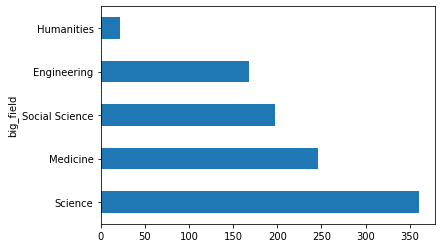

In [65]:
s_df.big_field.value_counts().plot.barh()

<Axes: ylabel='single_field'>

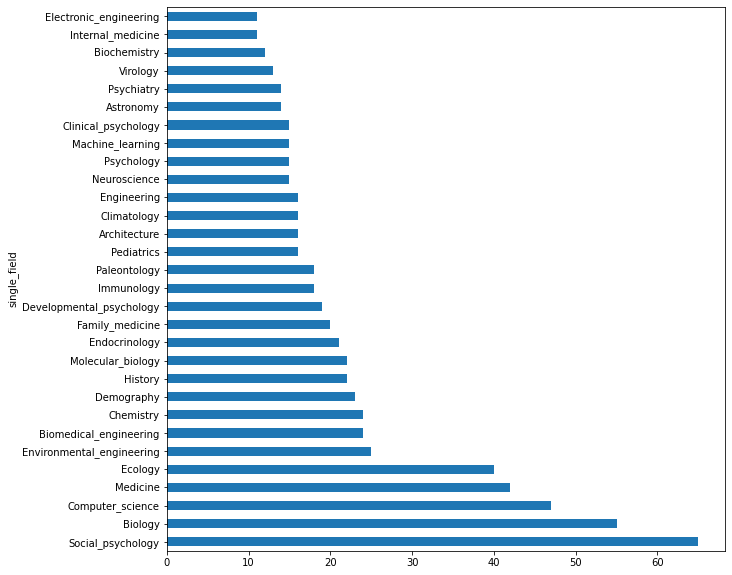

In [66]:
s_df.single_field.value_counts()[:30].plot.barh(figsize=(10, 10))

<Axes: >

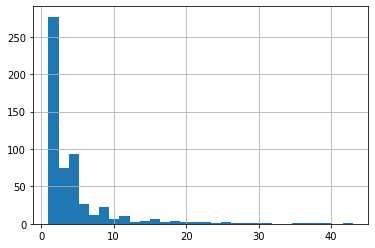

In [67]:
s_df.drop_duplicates('doi').coverage_cnt.hist(bins=30)

<Axes: ylabel='category'>

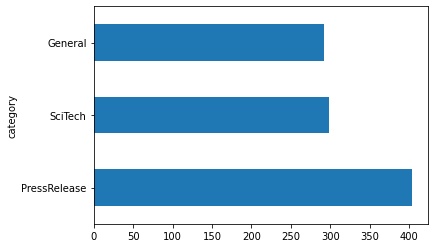

In [68]:
s_df.category.value_counts().plot.barh()

<Axes: ylabel='outlet'>

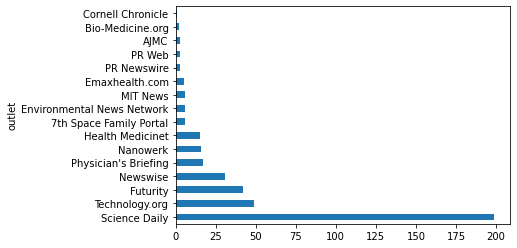

In [69]:
s_df[s_df.category=='PressRelease'].outlet.value_counts()[:30].plot.barh()

<Axes: ylabel='outlet'>

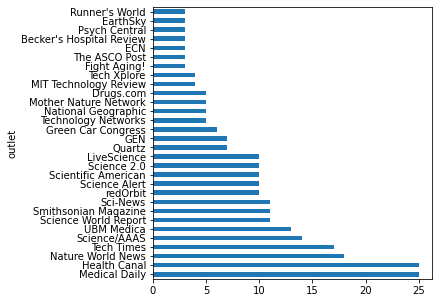

In [54]:
s_df[s_df.category=='SciTech'].outlet.value_counts()[:30].plot.barh(figsize=(5,5))

<Axes: xlabel='distance_to_pr', ylabel='Count'>

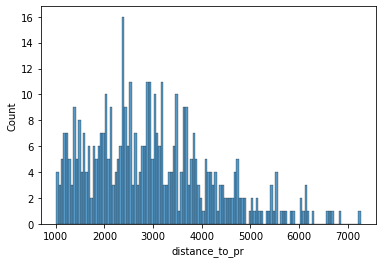

In [32]:
sns.histplot(s_df[s_df.category!='PressRelease'].distance_to_pr, binwidth=50)

In [958]:

s_df['remove'] = [True if re.search('Eyenuk Inc., uma empresa mundial|Kathy O\'Brien is a certified laughologist|Une seconde mission avait pour|COMMUNIQUE DE PRESSE INFORMATIONS|Science translational medicine', it) else False for it in s_df['raw_text']]
s_df['text'] = ['<div style="width: 1000px; height: 600px; overflow-y:scroll;"> Please read the following draft of a science news article and rate the statements below <hr size="10"> <strong>Title: %s</Strong> <br> <hr size="2"> %s </div>'%(clean_title(t),q.replace('\n','<br>')) for t,q in zip(s_df['Mention title'],s_df['raw_text'])]
print(len(s_df[s_df['remove']!=True]), len(s_df[s_df['remove']==True]))
s_df[s_df['remove']!=True].to_csv('../annotation/news_values/data_files/news_pair_sample_1000_batch2.csv',index=False)

1081 5


In [10]:
def clean_text(te):
    te = te.strip()
    if re.search('PRNewswire', te):
        te = re.split('\s--[\s]{0,1}', te)[-1].strip(' -\n/')
        #te = re.split('USNewswire', te)[-1].strip(' -\n/')
        if re.search('You just read:', te):
            te = te.split('You just read:')[0]
        te = re.split('More news releases in similar topics|original content to download|View original content', te)[0]
    if re.search('HealthDay', te):
        #te = re.split('\s--[\s]{0,1}', te)[-1].strip(' -\n/')
        te = re.split('\(HealthDay\)\s{0,1}--|\(HealthDay News\) --', te)[-1].strip(' -\n/')
        te = re.split('\n\n\(c\)|\n\nCopyright|\n\nAbstract/Full Text', te)[0]
        te = re.sub('\n\n.{0,25}--', '--', te)
        te = re.split('2018 -- ', te)[-1]
    if re.search('^\(c\)', te):
        te = te.split('\n\n\n\n')[-1]
    if re.search('NEWSWIRE', te):
        te = te.split('GLOBE NEWSWIRE')[-1]
    if re.search('You are free to share this article',te):
        te = re.sub('You are free to share this article under the Attribution 4.0 International license.{0,60}\n\n', '', te)
    te = re.sub('/ no comments\n\n|\(Newser\) -||\(Inside Science\) -|Newswise --|^.{0,10}\d{1,4}.{0,10}-|^.{0,50}201[0-9].{0,10}-', '', te).strip('\n\) -')
    te = re.sub('/ no comments\n\n|\(Newser\) -||\(Inside Science\) -|Newswise --|^.{0,10}\d{1,4}.{0,10}-|^.{0,50}201[0-9].{0,10}-|Share this\n\nArticle Facebook\n\nTwitter\n\nEmail', '', te).strip('\n\) -')
    te = re.sub('\n\n.{0,12}UPI', '', te)#.strip('\n\) -')
    te = re.sub('^.{0,30}UPI', '', te).strip('\n\) -')
    te = re.sub('\n\n\n.{0,60}\d{4}\s-', '', te).strip('\n\) -')
    te = re.sub('Please call 800-589-3331 to upgrade your subscription.','',te)
    te = te.split('65 6212 1000')[-1]
    te = te.replace('Video and photographs\n\nVancouver, BC, August 22nd, 2018 - ','')
    te = re.sub('\n+by\sStaff\sWriters\n+.{0,50}\d+\n+|\n+Published.{0,20}201[0-9].{0,3}\n+','\n', te)
    te = re.sub('\n+Released by.{0,50}\n+|\n+Patients newly diagnosed with|\n+[Aa]dvertisement:{0,1}\n+|\n+[Aa]dvertisement:{0,1}$|\n\n>>.{0,100}\n\n|\n\nRELATED.{0,100}\n\n|\n\nRELATED.{0,100}$|\n\nMore.{0,100}\n\n|\n+MORE.{0,60}\n+|\n\nMORE.{0,100}$','\n\n', te)
    te = re.split('\n\n\[Photo via|\n+Comments\n+comments|\n+Written by|\n\n---\n\n|\n+A full listing of papers included|\n+Continue reading|\n\nAbstract\n\nFull Text\n\nEditorial|\n+For more information|\n+For additional information|\n+By\sMargaret|\n\n\n\nRelated Links|\n+By\sNatalia Sanchez|\n+c\s\d{4}|\n+Chinese|\n+Contact|\n+Media\sContact|Correspondence|\n+MEDIA CONTACT|Contact:|\n+Correction|To learn more about the all-digital|To learn more about Venminder|To learn more about iCivics|Additional risks and uncertainties|\n+To learn more, please visit|\n+This article was originally published|\n#|\n+More information|\n+Read next', te)[0]
    te = re.split('\n+Source.{0,300}$|\n+SOURCE.{0,300}$', te)[0]
    te = re.split('\n+Research\spaper$', te)[0]
    te = te.replace('This article was originally published at The Conversation. The publication contributed the article to Live Science\'s Expert Voices: Op-Ed & Insights.\n\n','')
    te = re.split('\n+\(\'You Might Also Like|\n+Copyright|\n+This article is republished|\n+Read more at|\n+\(This story was updated|\n+To view PDF documents',te)[0]
    te = te.split('866-893-5722')[-1]
    te = re.split('By a News Reporter.{0,100}--|^Screenshot by.{0,50}\n|^Read Time:\n+|BUSINESS WIRE\)--',te)[-1]
    te = re.sub('\n{3,6}','\n\n', te)
    if re.search('Reuters', te):
        te = re.sub('^.{0,60}\s+-\s+','', te)
        te = te.replace('By Lisa Rapaport\n\n(Reuters Health) - ','')
        te = te.replace('By Julie Steenhuysen\n\nCHICAGO (Reuters) - ','')
    te = te.replace('This story was published in partnership with the Trace.','').replace('Embargoed until 4 a.m. CT / 5 a.m. ET Monday, March 26, 2018\n\n(NewMediaWire) - March 26, 2018 - DALLAS -','')
    if re.search('^.{0,20}-{1,2}',te):
        li = 'Washington, D.C. -|WASHINGTON, DC--|STRATFORD -|SALT LAKE CITY --|PARIS, France--|MANHATTAN, Kansas --|ITHACA, N.Y. -|HOUSTON -|CINCINNATI--|NEW YORK --|NEW YORK -|LOUISVILLE, Ky. -|(BRONX, NY)--|AMES, Iowa -|AMES, Iowa --|BINGHAMTON, N.Y. -'
        for l in li.split('|'):
            te = te.replace(l,'')
    return te.strip('#\n ')

def clean_title(te):
    te = te.replace('April 30 9:56 AM ','')
    return te.strip('#\n ')

def cal_distance(li,s):
     return min([lev.distance(l, s) for l in li])



def distance_to_pr(df, key = 'cleaned_text'):
    pr_dict = defaultdict(list)
    for i, row in df.iterrows():
        if row['category'] == 'PressRelease':
            pr_dict[row['doi']].append(row[key])
    
    if key != 'cleaned_text':
        df['distance_to_pr_raw'] = [cal_distance(pr_dict[row['doi']], row[key]) if (row['doi'] in pr_dict) and row['category'] != 'PressRelease' else None for i, row in tqdm(df.iterrows())]
        df['original_pr_raw'] = [pr_dict[row['doi']] if (row['doi'] in pr_dict) and row['category'] != 'PressRelease' and len(pr_dict[row['doi']]) == 1 else None for i, row in df.iterrows()]
    else:
        df['distance_to_pr'] = [cal_distance(pr_dict[row['doi']], row[key]) if (row['doi'] in pr_dict) and row['category'] != 'PressRelease' else None for i, row in tqdm(df.iterrows())]
        df['original_pr'] = [pr_dict[row['doi']] if (row['doi'] in pr_dict) and row['category'] != 'PressRelease' and len(pr_dict[row['doi']]) == 1 else None for i, row in df.iterrows()]
    return df

In [992]:
s_df.coverage_type.value_counts()

coverage_type
all_covered           237
engineering_sup       181
pr_gen_covered        160
pr_sci_covered        158
social_science_sup     88
coverage_10-30_sup     58
pr_only_covered        50
gen_only_covered       50
sci_only_covered       50
humanities_sup         28
coverage_30_sup        26
Name: count, dtype: int64

In [1034]:
s_df.remove.value_counts()

remove
False    1027
True       71
Name: count, dtype: int64

<Axes: xlabel='distance_to_pr', ylabel='Count'>

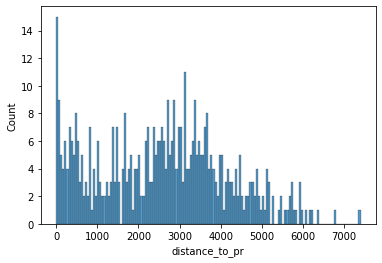

In [1004]:
sns.histplot(s_df[s_df.category!='PressRelease'].distance_to_pr, binwidth=50)

In [949]:
sorted([clean_title(te) for te in s_df['Mention title'] if re.search(r'Reuters', te)], reverse=True)

[]

In [957]:
sorted([clean_text(te) for te in s_df['raw_text'] if re.search(r'n the US, child', te)], reverse=True)

['n the US, child-resistant packaging for most medications has contributed to the prevention of thousands of pediatric deaths. Nevertheless, over 500,000 calls are made to poison control centers each year after accidental ingestion of medications by young children, and the number of emergency department visits for unsupervised medication ingestions is rising. In a new study scheduled for publication in The Journal of Pediatrics, researchers studied whether adding flow restrictors to bottles can limit the amount of liquid medication a child could access even if child-resistant caps are missing or improperly closed.\n\nStandard child-resistant packaging is designed to prevent or delay young children from opening bottles, giving caregivers reasonable time to intervene. However, in order for the packaging to work effectively, "Caregivers must correctly resecure the cap after each and every use. If the cap is not correctly resecured, children can open and drink whatever medication is in the

In [997]:
s_df[s_df['remove']==True].outlet.value_counts()

outlet
Health Canal                   17
Technology Networks            16
Benzinga                       14
ECN                            10
The Epoch Times                 6
Tech Xplore                     5
Space Daily                     4
Headlines & Global News         4
Psych Central                   4
Drugs.com                       3
Doctors Lounge                  3
Biospace                        3
Science World Report            3
My Science                      2
Astrobiology Magazine           2
Science 2.0                     2
Slate Magazine                  1
Sign of the Times               1
Green Car Congress              1
Seed Daily                      1
Equities.com                    1
Homeland Security News Wire     1
Name: count, dtype: int64

In [879]:
len(s_df)

1086

<Axes: ylabel='mention_year'>

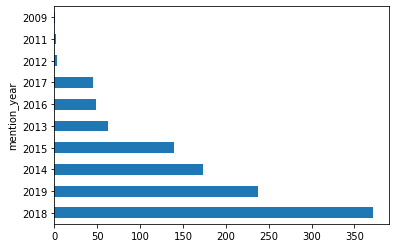

In [880]:
s_df['mention_year'].value_counts().plot.barh()

<Axes: ylabel='mention_year'>

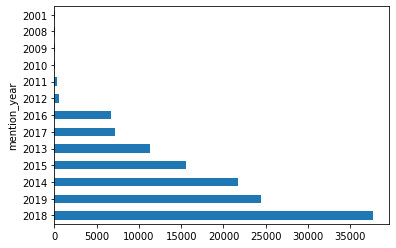

In [881]:
unique_df['mention_year'].value_counts().plot.barh()

In [882]:
s_df[(s_df['coverage_type']!='pr_only_covered')&(s_df['category']=='PressRelease')]['outlet']

109659                PR Newswire
865                 Science Daily
25724               Science Daily
122800                PR Newswire
63330                    Nanowerk
                   ...           
78743                    Newswise
114437             Technology.org
25873            Health Medicinet
122063    7th Space Family Portal
88048                    Futurity
Name: outlet, Length: 365, dtype: object

In [39]:
s_df[(s_df['coverage_type']=='pr_only_covered')&(s_df['category']=='PressRelease')]['outlet']

5433          Health Medicinet
84693                 Newswise
48690     Physician's Briefing
70037           Technology.org
114889                Nanowerk
60337                 Newswise
131466          Technology.org
34806         Health Medicinet
100491          Technology.org
131338                Nanowerk
32295         Health Medicinet
99855           Technology.org
108939                Futurity
100626          Technology.org
51174           Technology.org
15565         Health Medicinet
104496                Nanowerk
115873                MIT News
60916           Technology.org
35469         Health Medicinet
36958         Health Medicinet
130700          Technology.org
39785         Health Medicinet
62040           Technology.org
109435          Technology.org
67135                 Futurity
103827          Technology.org
82561                 Nanowerk
73191                 Newswise
78293           Technology.org
Name: outlet, dtype: object

In [45]:
s_df[['outlet','category','Mention title','coverage_type']]

,outlet,category,Mention title,coverage_type
129929,The University Herald,General,Preschool Math Should Focus On Patterns Not Nu...,pr_gen_covered
129928,Futurity,PressRelease,Preschool math should go beyond numbers - Futu...,pr_gen_covered
5433,Health Medicinet,PressRelease,Ringing in the ears and chronic pain enter by ...,pr_only_covered
84693,Newswise,PressRelease,Some Children Find It Harder to Understand Wha...,pr_only_covered
48690,Physician's Briefing,PressRelease,Decrease in Mean Platelet Counts Seen During P...,pr_only_covered
...,...,...,...,...
65727,ABC News,General,Curiosity Closer to Finding Habitable Environm...,all_covered
65725,Technology.org,PressRelease,SwRI scientists publish first radiation measur...,all_covered
10055,Science/AAAS,SciTech,New Results Send Mars Rover on a Quest for Anc...,all_covered
88852,Technology.org,PressRelease,"When a black hole shreds a star, a bright flar...",pr_sci_covered


In [883]:
s_df['outlet'].value_counts()

outlet
Science Daily        162
Technology.org        49
Newswise              45
Health Canal          37
Nanowerk              33
                    ... 
Houston Chronicle      1
Action News Now        1
Lifehacker             1
The Columbian          1
The ASCO Post          1
Name: count, Length: 158, dtype: int64

In [967]:
s_df['coverage_type']

27191      pr_only_covered
109660      pr_gen_covered
109659      pr_gen_covered
50814      engineering_sup
865        engineering_sup
                ...       
2674       pr_only_covered
105668    sci_only_covered
88050          all_covered
88048          all_covered
88051          all_covered
Name: coverage_type, Length: 1086, dtype: object

In [969]:
s_df.sort_values('doi')[['doi','cleaned_text','Mention title','distance_to_pr','coverage_type']].to_csv('batch_1_cleaned.csv')

In [57]:
df[df['outlet'] == 'Science Daily']['url'][4]

'http://www.sciencedaily.com/releases/2014/04/140418141121.htm?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%3A+sciencedaily+%28Latest+Science+News+--+ScienceDaily%29'

In [ ]:
# sample data for full batch 1
# more balanced outlets, especially for PR
# also include PR that are not covered in news 
cv_dict = {}
cv_dict['all_covered'] = re_df[(re_df.PressRelease!=0)&((re_df.General!=0)&(re_df.SciTech!=0))].sample(80)
cv_dict['pr_sci_covered'] = re_df[(re_df.PressRelease!=0)&((re_df.General==0)&(re_df.SciTech!=0))].sample(80)
cv_dict['pr_gen_covered'] = re_df[(re_df.PressRelease!=0)&((re_df.General!=0)&(re_df.SciTech==0))].sample(80)
cv_dict['pr_only_covered'] = re_df[(re_df.PressRelease!=0)&((re_df.General==0)&(re_df.SciTech==0))].sample(50)
cv_dict['gen_only_covered'] = re_df[(re_df.PressRelease==0)&((re_df.General!=0)&(re_df.SciTech==0))].sample(50)
cv_dict['sci_only_covered'] = re_df[(re_df.PressRelease==0)&((re_df.General==0)&(re_df.SciTech!=0))].sample(50)
cv_dict['social_science_sup'] = unique_df[(unique_df.big_field=='Social Science')].sample(50)
cv_dict['engineering_sup'] = unique_df[(unique_df.big_field=='Engineering')].sample(100)
cv_dict['humanities_sup'] = unique_df[(unique_df.big_field=='Humanities')&(unique_df.single_field!='Law')].sample(30)
cv_dict['coverage_10-30_sup'] = unique_df[(unique_df.coverage_cnt>10)&(unique_df.coverage_cnt<=30)].sample(20)
cv_dict['coverage_30_sup'] = unique_df[(unique_df.coverage_cnt>30)].sample(10)


sel_dois = set(pd.concat([cv_dict['all_covered'], cv_dict['pr_sci_covered'], cv_dict['pr_gen_covered'], cv_dict['pr_only_covered'], cv_dict['gen_only_covered'], 
                          cv_dict['sci_only_covered'], cv_dict['social_science_sup'], cv_dict['engineering_sup'], cv_dict['humanities_sup'], cv_dict['coverage_10-30_sup'], cv_dict['coverage_30_sup']])['doi'])

print(len(sel_dois))

doi2type = {}
for key,value in cv_dict.items():
    for doi in value['doi']:
        doi2type[doi] = key

s_df = sample_from_dois(unique_df, sel_dois)
s_df['coverage_type'] = [doi2type[doi] for doi in s_df['doi']]

In [92]:
def load_jsonl_folder(folder_path):
    # Get a list of all files in the folder with the .jsonl extension
    jsonl_files = [file for file in os.listdir(folder_path) if file.endswith('.jsonl')]
    
    # Initialize an empty list to store the data from all JSONL files
    all_data = []
    
    # Loop through each JSONL file and load its contents
    for file_name in tqdm(jsonl_files):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r') as file:
            lines = file.readlines()
            for line in lines:
                try:
                    data = pd.read_json(line, lines=True)
                    all_data.append(data)
                except:
                    print(file_path)
    
    # Concatenate all loaded data into a single DataFrame
    df = pd.concat(all_data, ignore_index=True)
    
    return df

def process_eurek(df):
    df = pd.concat([df, pd.DataFrame().from_records(list(df.media_contact))] , axis=1)
    df['from_university'] = [str(it)[-4:]=='.edu' for it in list(df['email'])]
    df['release_year'] = [str(it)[-4:] for it in df.release_date]
    df['doi'] = [str(it)[18:] if len(str(it))>4 else np.nan for it in tqdm(df['related_journal_article_link'])]
    
    return df

def get_eurek_dict(df):
    res = {}
    for i,row in df.iterrows():
        res[row['doi']] = dict(row)
    return res

def attach_eurek_data(df, eurek_dict):
    res = defaultdict(list)
    for doi in tqdm(df['doi']):
        if doi in eurek_dict:
            for key in ['page_title', 'full_text', 'keywords']:
                res[key].append(eurek_dict[doi][key])
        else:
            for key in ['page_title', 'full_text', 'keywords']:
                res[key].append(np.nan)
    for key in res:
        df[key] = res[key]
    print(len(df[~df['page_title'].isna()]))
    return df

In [61]:
folder_path = '/shared/3/projects/jiaxin/datasets/eurekalert/wget/archive.eurekalert.org/extracted4match/'
eurek = load_jsonl_folder(folder_path)

 28%|██▊       | 30/107 [03:07<07:12,  5.62s/it]

/shared/3/projects/jiaxin/datasets/eurekalert/wget/archive.eurekalert.org/extracted4match/2014-06.jsonl


100%|██████████| 107/107 [12:22<00:00,  6.94s/it]


In [63]:
eurek = process_eurek(eurek)

100%|██████████| 261542/261542 [00:00<00:00, 1014768.11it/s]


In [81]:
eurek_dois = set(eurek['doi'])
eurek_dict = get_eurek_dict(eurek)

In [95]:
unique_df = attach_eurek_data(unique_df, eurek_dict)

100%|██████████| 125685/125685 [00:00<00:00, 635689.12it/s]


28596


In [134]:
len(set(unique_df.doi) & eurek_dois) / len(set(unique_df.doi))

0.18277881663902903

In [135]:
4131 / len(unique_df[(unique_df['outlet']=='Science Daily')])

0.2653179190751445

In [146]:
len(unique_df[(unique_df['category']=='General')&(~unique_df['page_title'].isna())]) / len(unique_df[(unique_df['category']=='General')])

0.1794089550399063

In [142]:
tt_df = unique_df[(unique_df['category']=='General')&(~unique_df['page_title'].isna())]

In [139]:
tt_df['page_title'] = [it.strip() for it in tt_df['page_title']]
tt_df['Mention title'] = [it.replace(' -- ScienceDaily','') for it in tt_df['Mention title']]

<ipython-input-139-22727719097c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt_df['page_title'] = [it.strip() for it in tt_df['page_title']]
<ipython-input-139-22727719097c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt_df['Mention title'] = [it.replace(' -- ScienceDaily','') for it in tt_df['Mention title']]


In [143]:
tt_df[['Mention title', 'page_title']]

,Mention title,page_title
6,Scientists Hope Lab-Grown Embryos Can Save Rhi...,A breakthrough to rescue the Northern White Rhino
7,Northern White Rhino: World's Most Endangered ...,A breakthrough to rescue the Northern White Rhino
8,Scientists hope test-tube embryos can save nea...,A breakthrough to rescue the Northern White Rhino
9,Saving The Northern White Rhino's Genes Is Imp...,A breakthrough to rescue the Northern White Rhino
10,IVF Could Resurrect Functionally-Extinct North...,A breakthrough to rescue the Northern White Rhino
...,...,...
133602,"Study shows money linked to happiness, but onl...",Money only buys happiness for a certain amount
133604,The World Is Still at Record Levels of Sadness...,Money only buys happiness for a certain amount
133664,Renewable Energy Linked To A 5.5 Mag Earthquak...,Mw 5.4 Pohang earthquake tied to geothermal ac...
133665,Earthquakes from underground water injection c...,Mw 5.4 Pohang earthquake tied to geothermal ac...


In [144]:
tt_df[tt_df['Mention title']!=tt_df['page_title']][['Mention title', 'page_title']]

,Mention title,page_title
6,Scientists Hope Lab-Grown Embryos Can Save Rhi...,A breakthrough to rescue the Northern White Rhino
7,Northern White Rhino: World's Most Endangered ...,A breakthrough to rescue the Northern White Rhino
8,Scientists hope test-tube embryos can save nea...,A breakthrough to rescue the Northern White Rhino
9,Saving The Northern White Rhino's Genes Is Imp...,A breakthrough to rescue the Northern White Rhino
10,IVF Could Resurrect Functionally-Extinct North...,A breakthrough to rescue the Northern White Rhino
...,...,...
133602,"Study shows money linked to happiness, but onl...",Money only buys happiness for a certain amount
133604,The World Is Still at Record Levels of Sadness...,Money only buys happiness for a certain amount
133664,Renewable Energy Linked To A 5.5 Mag Earthquak...,Mw 5.4 Pohang earthquake tied to geothermal ac...
133665,Earthquakes from underground water injection c...,Mw 5.4 Pohang earthquake tied to geothermal ac...


In [147]:
5778 / 5822

0.992442459635864

In [129]:
list(tt_df[tt_df['Mention title']!=tt_df['page_title']][['Mention title', 'page_title']]['Mention title'])[:20]

['A breakthrough to rescue the Northern White Rhino: First ever hybrid embryo produced outside the womb',
 'Could a particle accelerator using laser-driven implosion become a reality? Scientists discover new particle acceleration by micro-bubbles',
 'The universality of shame',
 "Skin's immune 'alarm' may explain light-induced rashes in lupus patients: Researchers are studying an overabundant signaling protein tied to UV light sensitivity in patients with lupus",
 'Next 5 years predicted to be abnormally hot',
 "Study unlocks full potential of 'supermaterial' graphene: Researchers remove silicon contamination from graphene to double its performance",
 'How fruits got their eye-catching colors: Fruits owe their rainbow of colors to the various animals that eat them',
 'Like mountaineers, nerves need expert guidance to find their way: Scientists discover that motor neurons receive a multitude of cues to successfully navigate to their destinations in the body',
 'Why chikungunya, other ar

In [130]:
list(tt_df[tt_df['Mention title']!=tt_df['page_title']][['Mention title', 'page_title']]['page_title'])[:20]

['A breakthrough to rescue the Northern White Rhino',
 'Could a particle accelerator using laser-driven implosion become a reality?',
 'The value of pride',
 "Skin's immune 'alarm' may explain light-induced rashes in lupus patients",
 '2018-2022 expected to be abnormally hot years',
 "Study unlocks full potential of 'supermaterial' graphene",
 'How fruits got their eye-catching colors',
 'Like mountaineers, nerves need expert guidance to find their way',
 'NIH-funded researchers identify target for chikungunya treatment',
 'NIH-funded researchers identify target for chikungunya treatment',
 'Research enhances enzyme that degrades plastic',
 'Of hearts and giants: Moving a cardiac regulatory protein to the right place',
 'Rare pediatric skin conditions often get expensive, inconsistent care',
 'Rutgers researchers create a 3D-printed smart gel that walks underwater, moves objects',
 "Neandertals' main food source was definitely meat",
 'Asian elephants could be the maths kings of the ju

In [137]:
tt_df[tt_df['Mention title']!=tt_df['page_title']][['Mention title', 'page_title']].to_csv('../data/science_daily_unmatched_sample.csv', index=False)